In [118]:
import sys
import os
import re
import psycopg2 # ignore the warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [119]:
# there are so many ways OH can be listed:
# "My office hours/Office Hours/OH is/are from 2 to/- 5"
# "Office Hours: 2-5"
# "OH: 2-5"
# "The TA, Karen, holds her office hours/Office Hours/OH at 2 for 1 hour"
# etc.

In [120]:
# We don't want to approach this problem in a "let's brute force all combinations"
# Instead, let's attempt to catch the context that the term "office hours"/"Office Hours"/"OH" appears
# We could use techniques such as lemmatization to do this, but for this example, let's stick to a basic formula

In [121]:
# It would make sense that, with high certainty, the term "office hours" (and its related counterparts) will be in close proximity to its respective times
# To see if this is the case, we'll test on a few sample syllabi
# When we find the occurance of the term "office hours" or similar, we'll extract the previous and next n characters
# Perhaps we'll see that there's a general consensus of context the term "office hours" falls in
# and if so, we can use that context to extract the office hour times

In [122]:
# let's run through a few syllabi and attempt to do this
try:
    conn = psycopg2.connect("dbname='litindex' user='python' host='3.16.15.91' password='python'")
except:
    print("Connection failed")
    
cur = conn.cursor()

In [123]:
cur.execute("SELECT id, content FROM syllabus LIMIT 20")
context_store = {}

for row in cur:
    context_store[row[0]] = []
    
    oh_string = re.compile('[Oo]ffice\W+[Hh]ours|OH')
    
    for match in oh_string.finditer(row[1]):
        context_store[row[0]].append(row[1][match.start()-50:match.start()+len(match.group())+50])

In [124]:
# let's see what we get   
for id in context_store:
    print(context_store[id])

['M 228 Bliss Annex Professor Cathy Day Bliss \r\n229 Office \r\nHours: F 12:30-3:30 PM and by appointment ( use sign up']
['Location:\nInstructor:\nOffice:\nPhone:\nFax:\nE-mail:\nOffice Hours:\n\n12:00pm – 1:50pm, Mondays & Thursdays\n*classes ']
['ce: Science Complex SCP 246\nE-mail: bobc@tcnj.edu\nOffice Hours: Mon. 2-4, Thur.11:30-12:30 and by appointment\nCo']
[]
[]
['\nFall 2005\n\nBliss 226, ext. 3048\n\nblake@tcnj.edu\n\nOH: M Th 3:30-4:15; F 3-5;\n\nand by appointment\n\nLIT ', 'tructor has explained the\nprinciple (in class, in office hours, or in the paper’s annotations),\nthe repetition o']
["\n\nKomagata , komagata@tcnj.edu , Holman Hall 229, Office hours: See the instructor's on-line weekly schedule On-"]
[]
['essor: Lee Ann\r\nRiccardi Office: 304 Holman\r\nHall Office Hours:\r\nMondays, 11:00am-12:20pm, Thursdays, 2:00-3:20p']
['l: hagedorn@tcnj.edu\n\nOffice: Science Complex 207\nOffice Hours: M: 4-5:30, Th: 1:30-3, and by\nappointment.\n\nBook']
["o\nKomagata , komag

In [125]:
# I'm glad we ran through that
# First, some syllabi don't have the term "Office Hours" or related, at least not in a conventional format
# Second, we see that not all "Office Hours" are contained in a context listing the times they're held
# Third, there could be multiple office hours that are offered in a course
# As a simple rule, it appears that, as hypothesized, valid contexts of office hours are indicated, at least in part, by time ranges in close proximity
# For the purpose of this analysis, we'll stick to analyzing the times of day they're held. We'll also hold off on handling the non-matches (empty lists), though that is a very valid concern

# Let's use regex and attempt to extract the different times

times_per_course = {}
for syllabi in context_store:
    times_per_course[syllabi] = []
    
    for context in context_store[syllabi]:
        # print(context)
        vals = re.search(r'(\d\d?(?:[\.:]\d\d)?\s*(?:am|AM|pm|PM|a.m.|A.M.|p.m.|P.M.)?\s*[-–]\s*\d\d?(?:[\.:]\d\d)?\s*(?:am|AM|pm|PM|a.m.|A.M.|p.m.|P.M.)?)', context)
        
        if vals is not None:
            for elem in vals.groups():
                times_per_course[syllabi].append(elem)
            
print(times_per_course)

{674730772267030: ['12:30-3:30 PM'], 249460290487768: ['12:00pm – 1:50pm'], 71270687310727: ['2-4'], 383669428551790: [], 69947837384437: [], 656709089493002: ['3:30-4:15'], 653066957226037: [], 628791802069062: [], 644451252830279: ['11:00am-12:20pm'], 59811714564127: ['4-5:30'], 592963184885796: [], 55499567399288: ['1.30 pm-3.00 p.m.'], 74552042325894: ['09-77', '09-77'], 621713695965276: ['12-1:30pm'], 642252229574736: [], 599998341316708: [], 185886184572674: [], 230390635693063: [], 625493267185729: ['9:30-10:50'], 558457417629957: []}


In [126]:
# OK, seems like we still have some problems, but we'll roll with this.
# Unfortunately, our regex pattern still catches phone numbers
# With this data, we can conduct further analysis knowing that with a high degree of certainty
# These times represent the office hour times
# From first glance, it seems like a lot of the office hours take place between 12-4
# Seems like that could be considered the rush hour of OH, when most people are on campus

In [127]:
# Let's see if we can extract days from these contexts too
# As a very naive rule for the sake of this example, let's say we have a Monday match if Monday/Mon/etc. is found in the OH context
# Obviously, not every Monday match will explicitly refer to the office hour times
# Remember, we're not aiming for 100% accuracy, but rather an overall view
# We'll need a few more samples as I plan to plot a bar chart of number of syllabi offering 

cur.execute("SELECT id, content FROM syllabus LIMIT 100")
context_store = {}

for row in cur:
    context_store[row[0]] = []
    
    oh_string = re.compile('[Oo]ffice\W+[Hh]ours|OH')
    
    for match in oh_string.finditer(row[1]):
        context_store[row[0]].append(row[1][match.start()-50:match.start()+len(match.group())+50])

In [128]:
# One more thing: we won't be searching for M = Monday matches, as there are too many M's in a single context
# And we won't be looking at weekends: seriously you should take the weekend off
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
oh_days = {d: 0 for d in days}

for syllabi in context_store:
    for context in context_store[syllabi]:
        mondays = re.findall(r'Mon', context) # should catch Monday too
        tuesdays = re.findall(r'Tue', context)
        wednesdays = re.findall(r'Wed', context)
        thursdays = re.findall(r'Thur', context)
        fridays = re.findall(r'Fri', context)
        
        oh_days['Mon'] += len(mondays)
        oh_days['Tues'] += len(tuesdays)
        oh_days['Wed'] += len(wednesdays)
        oh_days['Thurs'] += len(thursdays)
        oh_days['Fri'] += len(fridays)
        
print(oh_days)

{'Mon': 13, 'Tues': 17, 'Wed': 8, 'Thurs': 19, 'Fri': 10}


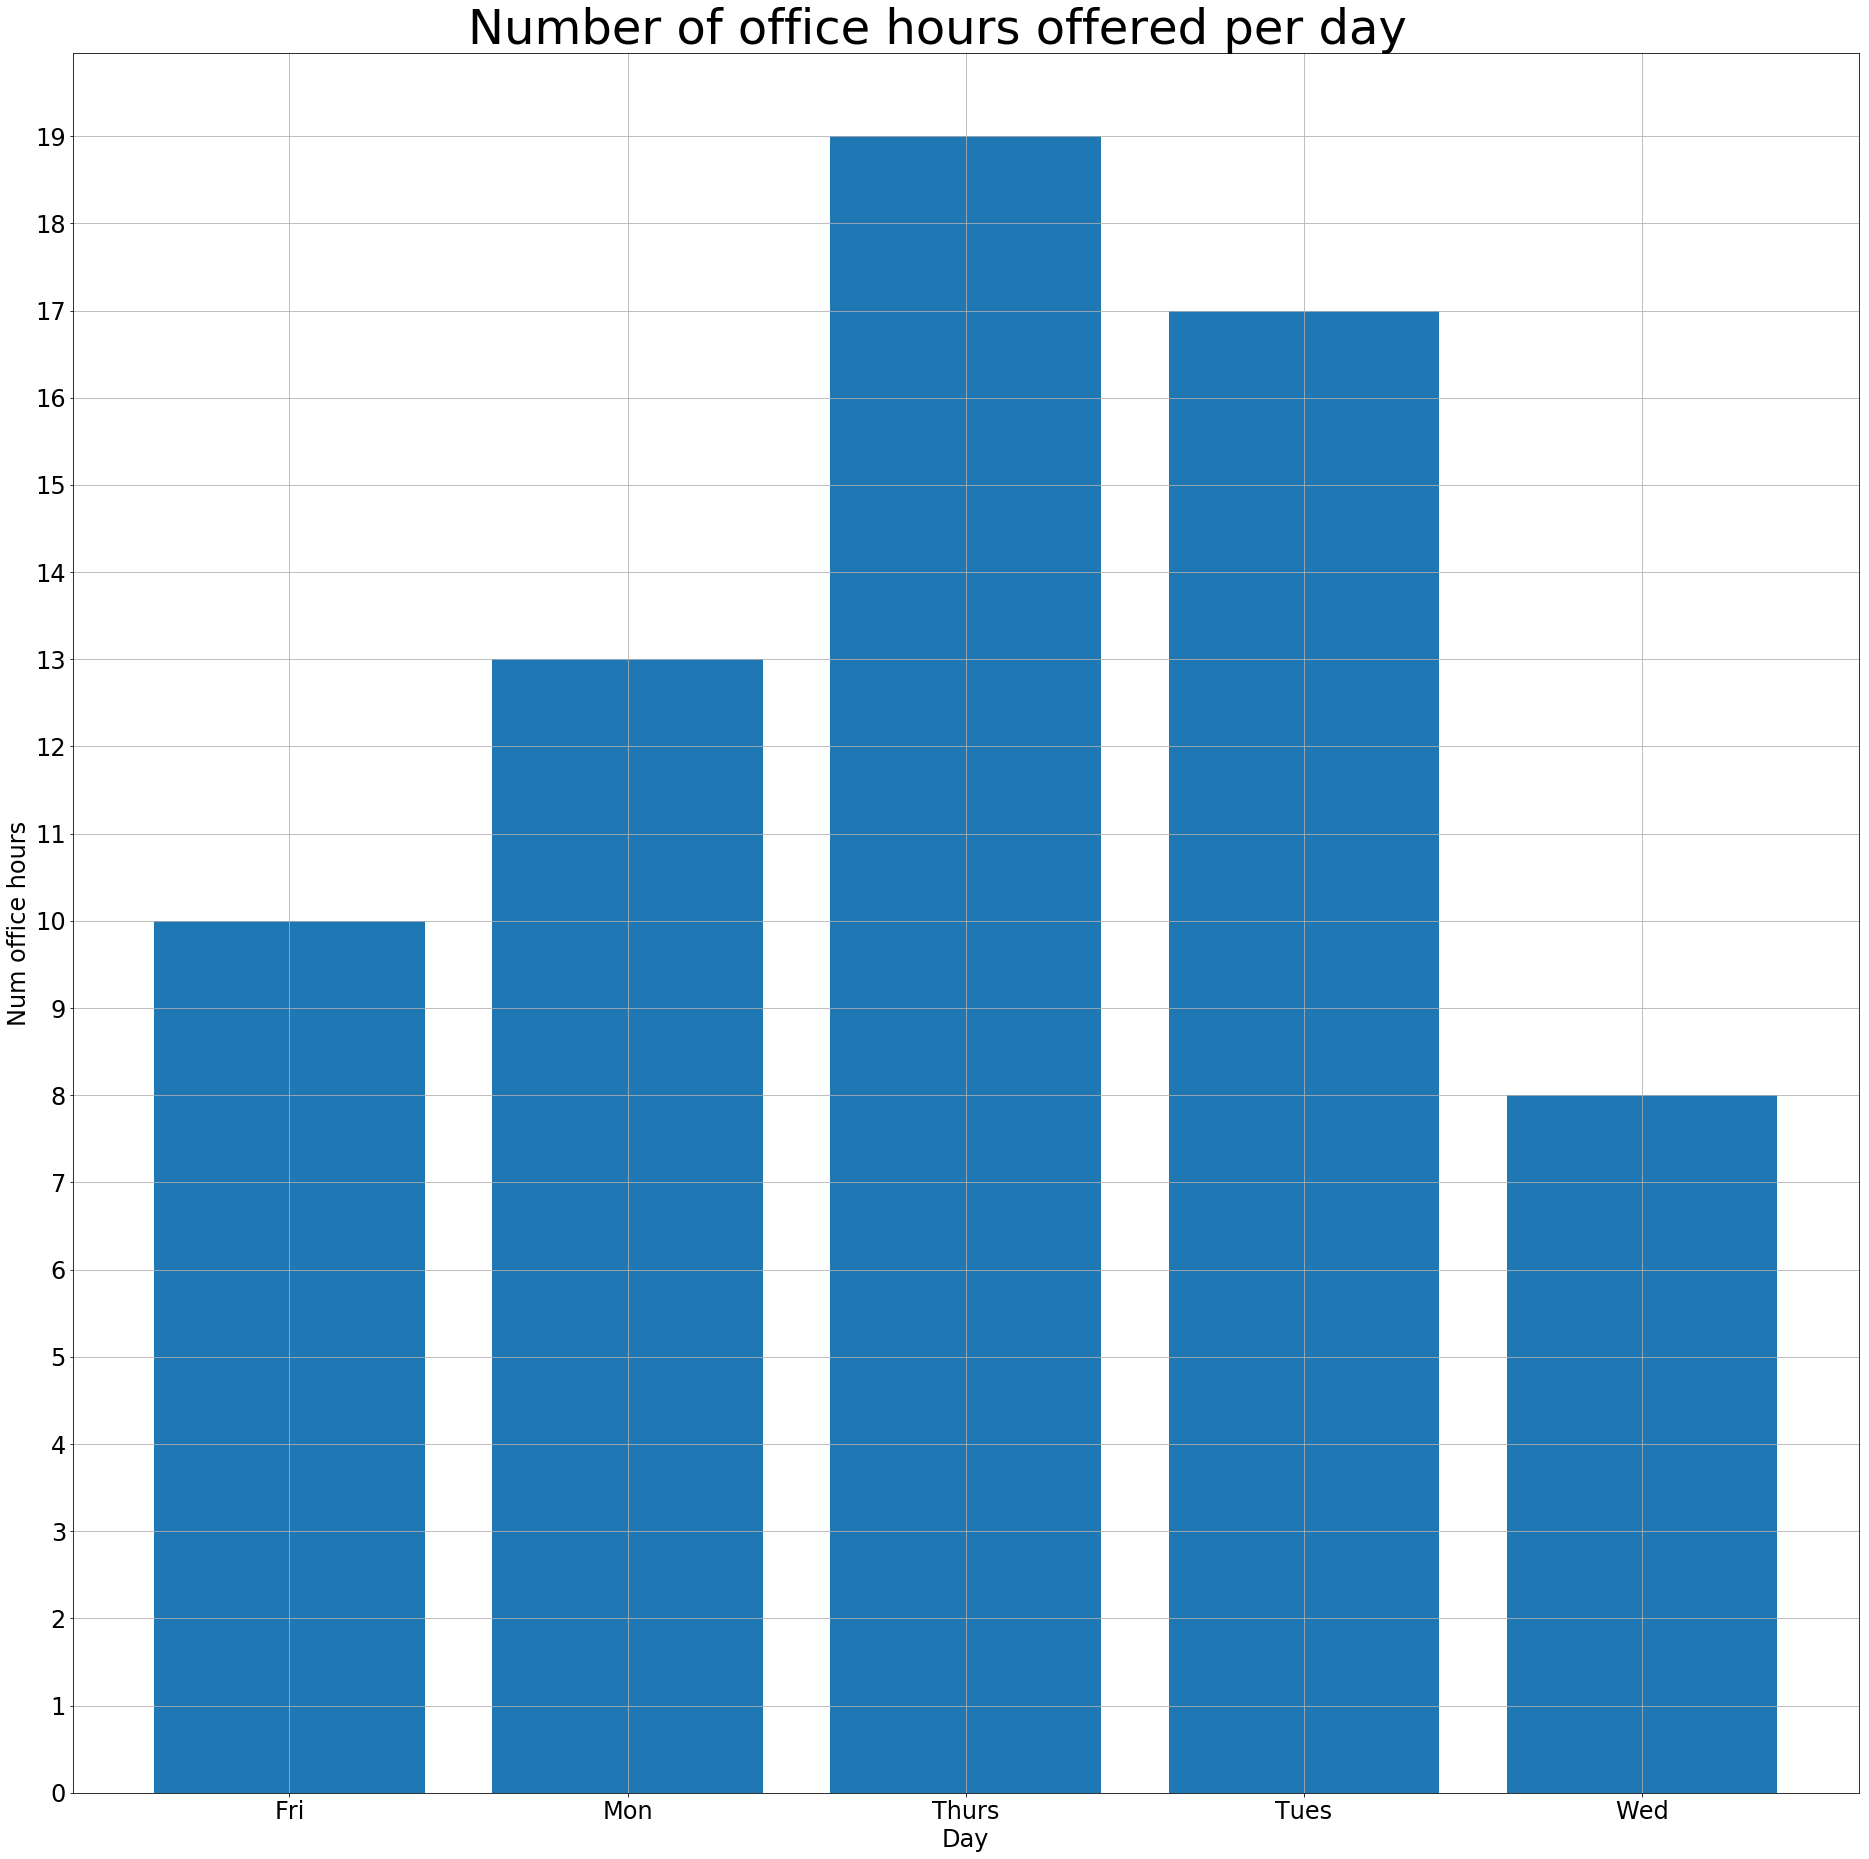

In [132]:
# now let's plot our bar chart
day = list(oh_days.keys())
count_oh = [oh_days[x] for x in oh_days]

_ = plt.figure(figsize=(32, 32))
_ = plt.bar(day, count_oh)
_ = plt.tick_params(axis='both', which='major', labelsize=24)
_ = plt.tick_params(axis='both', which='minor', labelsize=24)
# _ = plt.xticks(range(len(count_oh)), day)
_ = plt.yticks(np.arange(0, 20, 1))
_ = plt.xlabel('Day', fontsize=24)
_ = plt.ylabel('Num office hours', fontsize=24)
_ = plt.suptitle("Number of office hours offered per day", fontsize=48, y = .9)
_ = plt.grid()

In [130]:
# From these 100 records, it seems like Tuesdays and Thursdays are the most popular days to hold OH
# Wednesdays and Fridays not so much
# It would be interesting to group these by department to see if we can extract specific trends

In [131]:
conn.close()